In [1]:
import sys
sys.path.append('/home/lxpollara/pyvpic')
sys.path.append('/home/lxpollara/Adas_Proj')
from sql_alchemy_engine import session, Base
from create_db import AccidentMaster, Vehicle
import pandas as pd
from vpicwrapper import pyvpic
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy.stats import binom_test, chisquare, poisson, geom
from sqlalchemy import func
import numpy as np
from query_widget import DashBoard

# Calculating the Average Number of Injuries:
The number of injuries in an accident is a discrete random variable. To compare the performance of individual vehicles to the general population we will first calculate the rates of each number of injuries for the general population of vehicles So we count the number of accidents for each number of injuries (filtered here to look only at Class 8 vehicles).the rates for each number of victims can than be compared for any subpopulation using the ChiSquared test for goodness of fit.

In [2]:
# format query and bind to dataframe
query = session.query(AccidentMaster.injuries, func.count(AccidentMaster.injuries)).filter(AccidentMaster.vehicle_config>8,
                                                                                           AccidentMaster.vehicle_config<99,
                                                                                          AccidentMaster.vehicles_involved<=2).group_by(AccidentMaster.injuries)
injuries = pd.read_sql(query.statement,query.session.bind)
injuries['Rate'] = injuries.count_1/injuries.count_1.sum()


avg_glob = (injuries.count_1*injuries.injuries).sum()/float(injuries.count_1.sum())

In [4]:

injuries.iloc[10]=injuries.iloc[10:].sum()
injuries.drop(injuries.index[11:], inplace=True)
injuries.loc[10, 'injuries']=10


We want a concise way to compare injuries between different populations to do this we will compare the average injury rate calculated for the total population to the observed rate for any sub population. 

In [5]:
print avg_glob

0.409022630732


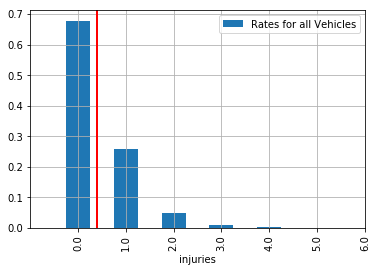

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
injuries.plot(y='Rate', x='injuries', kind='bar', ax=ax, label='Rates for all Vehicles')
plt.grid()
ax.axvline(avg_glob, color='r', linewidth=2, label='Average number of injuries')
plt.xlim(-1,6)
plt.show()

# Comparing Sub-populations to the Overall Population
Now we want to compare a particular sub population to the overall population. We will do this once as an example before running this analysis for larger groups. For starters we will use the Volvo VNL 2007, a vehicle we suspect has a slightly better injury rate than the general population.

In [60]:
# format query and bind to dataframe
query = session.query(AccidentMaster.injuries, func.count(AccidentMaster.injuries)).filter(AccidentMaster.vin==Vehicle.vin,
                                                                                           Vehicle.make=='VOLVO TRUCK',
                                                                                           Vehicle.model=='VNL',
                                                                                           Vehicle.year==2007,
                                                                                           AccidentMaster.vehicles_involved<=2
                                                                                          ).group_by(AccidentMaster.injuries)
vnl_injuries = pd.read_sql(query.statement,query.session.bind)
vnl_injuries['Rate'] = vnl_injuries.count_1/vnl_injuries.count_1.sum()


avg_vnl = (vnl_injuries.count_1*vnl_injuries.injuries).sum()/float(vnl_injuries.count_1.sum())

The average injury rate for the 2007 VOLVO TRUCKS VNL is:

In [61]:
print avg_vnl

0.377313145878


In [62]:
joined = injuries.join(vnl_injuries[['count_1', 'Rate']], rsuffix= '_VNL').fillna(0)
joined.iloc[1]=joined.iloc[1:].sum()
joined.drop(joined.index[2:], inplace=True)
joined.loc[1, 'injuries']=1
chisquare(joined.count_1_VNL.values, joined.Rate.values*joined.count_1_VNL.sum())

Power_divergenceResult(statistic=6.7370014375157776, pvalue=0.009443322199587172)

In [63]:
print joined.count_1_VNL.sum()
joined

4161.0


,injuries,count_1,Rate,expected,count_1_VNL,Rate_VNL
0,0.0,178391.0,0.678393,174684.781556,2901.0,0.697188
1,1.0,84570.0,0.321607,88276.218443,1260.0,0.302812


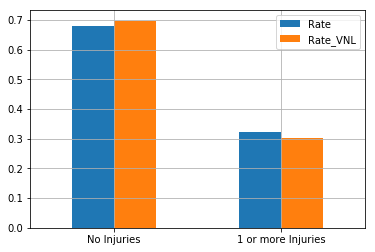

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111)
joined[['Rate', 'Rate_VNL']].plot(kind='bar', ax=ax)
plt.xticks([0,1], ['No Injuries', '1 or more Injuries'], rotation='horizontal')
plt.grid()
plt.show()

In [7]:
population = DashBoard()

A Jupyter Widget

In [18]:
pop_injuries=population.accidents1
pop_injuries['Rate'] = pop_injuries.count_1/pop_injuries.count_1.sum()


joined = injuries.join(pop_injuries[['count_1', 'Rate']], rsuffix= '_pop').fillna(0)
joined.iloc[1]=joined.iloc[1:].sum()
joined.drop(joined.index[2:], inplace=True)
joined.loc[1, 'injuries']=1


pop_avg = (pop_injuries.count_1*pop_injuries.injuries).sum()/float(pop_injuries.count_1.sum())
print 'Population size: '+str(joined.count_1_pop.sum())
print 'Total Avg: '+str(avg_glob)
print 'Population Avg '+str(pop_avg)
print 'zero rate '+ str(joined.Rate_pop[0])

print chisquare(joined.count_1_pop.values, joined.Rate.values*joined.count_1_pop.sum())

Population size: 7250.0
Total Avg: 0.409022630732
Population Avg 0.380413793103
zero rate 0.702482758621
Power_divergenceResult(statistic=19.283365615926421, pvalue=1.1268380619897965e-05)


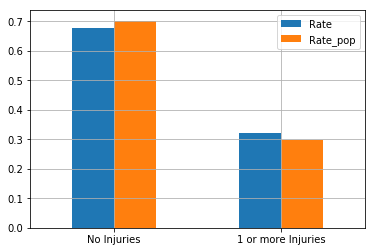

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
joined[['Rate', 'Rate_pop']].plot(kind='bar', ax=ax)
plt.xticks([0,1], ['No Injuries', '1 or more Injuries'], rotation='horizontal')
plt.grid()
plt.show()